In [46]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


In [2]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
df = pd.read_parquet(url, engine="pyarrow")

In [4]:
df.head(3)

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            43           151              1.0           1.01   
1         1.0           166           239              1.0           2.53   
2         1.0            41            42              1.0           1.12   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount ehail_fee  \
0          5.5    0.5      0.5        0.00           0.0      None   
1         10.0    0.5      0.5        2.81           0.0      None   
2          6.0    0.5      0.5        1.00           0.0      None   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3          6.80           2.0        1.0   
1                    0.3         16.86           1.0        1.0   
2                    0.3          8.30           1.0        1.0   

   congestion_surcharge  
0                  0.00  
1                  2.75  
2                  0.00

In [5]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime ) # we need to convert strings to datetime

In [6]:
df.trip_type.unique().tolist()

[1.0, 2.0, nan]

In [7]:
# create a new col
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime 

# Convert timedelta to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [ ]:
#df = df[df.trip_type == 2] # interested in this type of trip

In [8]:
df.duration.describe(percentiles= [0.95,0.98,0.99 ])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [9]:
# frombuisness point of view, it's imp to pay attention to this --> 98%-> around 1 hour

In [10]:
# we can do extra filtering, only attention to those trip the at least one minutes.

((df.duration >= 1) & (df.duration <= 60)).mean()


0.9658903787344154

In [11]:
df= df[((df.duration >= 1) & (df.duration <= 60))]
df # all data regardless of different trip type

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0             2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1             2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2             2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3             2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
7             2  2021-01-01 00:26:31   2021-01-01 00:28:50                  N   
...         ...                  ...                   ...                ...   
76513         2  2021-01-31 21:38:00   2021-01-31 22:16:00               None   
76514         2  2021-01-31 22:43:00   2021-01-31 23:21:00               None   
76515         2  2021-01-31 22:16:00   2021-01-31 22:27:00               None   
76516         2  2021-01-31 23:10:00   2021-01-31 23:37:00               None   
76517         2  2021-01-31 23:25:00   2021-01-31 23:35:00               None   

       RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0             1.0            43           151              1.0           1.01   
1             1.0           166           239              1.0           2.53   
2             1.0            41            42              1.0           1.12   
3             1.0           168            75              1.0           1.99   
7             1.0            75            75              6.0           0.45   
...           ...           ...           ...              ...            ...   
76513         NaN            81            90              NaN          17.63   
76514         NaN            35           213              NaN          18.36   
76515         NaN            74            69              NaN           2.50   
76516         NaN           168           215              NaN          14.48   
76517         NaN           119           244              NaN           1.81   

       fare_amount  ...  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0             5.50  ...      0.5        0.00          0.00       None   
1            10.00  ...      0.5        2.81          0.00       None   
2             6.00  ...      0.5        1.00          0.00       None   
3             8.00  ...      0.5        0.00          0.00       None   
7             3.50  ...      0.5        0.96          0.00       None   
...            ...  ...      ...         ...           ...        ...   
76513        56.23  ...      0.0        0.00          6.12       None   
76514        46.66  ...      0.0       12.20          6.12       None   
76515        18.95  ...      0.0        0.00          0.00       None   
76516        48.87  ...      0.0        0.00          6.12       None   
76517        15.45  ...      0.0        0.00          0.00       None   

      improvement_surcharge  total_amount  payment_type  trip_type  \
0                       0.3          6.80           2.0        1.0   
1                       0.3         16.86           1.0        1.0   
2                       0.3          8.30           1.0        1.0   
3                       0.3          9.30           2.0        1.0   
7                       0.3          5.76           1.0        1.0   
...                     ...           ...           ...        ...   
76513                   0.3         65.40           NaN        NaN   
76514                   0.3         65.28           NaN        NaN   
76515                   0.3         22.00           NaN        NaN   
76516                   0.3         58.04           NaN        NaN   
76517                   0.3         18.50           NaN        NaN   

       congestion_surcharge   duration  
0                      0.00   3.933333  
1                      2.75   8.750000  
2                      0.00   5.966667  
3                      0.00   7.083333  
7                      0.00   2.316667  
...                     ...        ...  
76513                   NaN  38.000000  
76514          

In [12]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [13]:
# let's train a model, 

In [14]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [15]:
# for implementing the onehot encoding we can implemnt dictinoary vectorizer
# dictionary vectorizer treat everything that is not numbrer as a categorical varible

In [16]:
# Convert int to category when numbers represent labels, not quantities.
# we do for clarity, memory efficiency and at the end we encode categories numerically

df[categorical].astype(str).dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [17]:
df[categorical] = df[categorical].astype(str)

In [18]:
# we have now dataframe, we need dic though

In [19]:
dv = DictVectorizer() # vectorizes a dictionary. dic --> vector

In [20]:
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [21]:
#apply to the entire dataframe
train_dicts= df[categorical + numerical].to_dict(orient='records')

In [22]:
# then we can put inside our dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [23]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [24]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [25]:
target = 'duration'
y_train= df[target].values

In [26]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [27]:
# Baseline Model --> Linear Regression

In [28]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [29]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


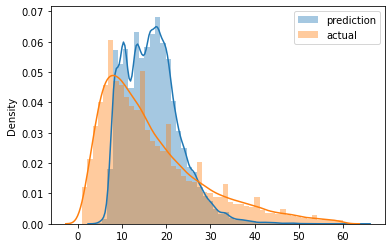

In [30]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

In [ ]:
# prection of actual value is different, lest quatifize that

In [ ]:
mean_squared_error(y_train, y_pred, squared=False) #  returns the RMSE

In [ ]:
# our model is (error)wrong on average by 9 min, it's not ideal
# you want to reach somewhere by 30 min, but it turns out thta it take 40 min

In [ ]:
# - Lasso

In [ ]:
# create all we did and put all inside a function 

In [ ]:
# All the preprocessing we need to do: 

In [33]:
def read_dataframe(url):
    
    df = pd.read_parquet(url, engine="pyarrow")

   # url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
   # df = pd.read_parquet(url, engine="pyarrow")

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime ) 

    # create a new col
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime 

    # Convert timedelta to minutes
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[((df.duration >= 1) & (df.duration <= 60))] # intrested in this timeline

    categorical = ['PULocationID','DOLocationID'] # only preprocessing for cat
    

    df[categorical] = df[categorical].astype(str)
    
    return df

In [34]:
# January data = training
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")

# February data = validation
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")


In [35]:
len(df_train), len(df_val)

(73908, 61921)

In [39]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts= df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts= df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [40]:
target = 'duration'
y_train= df_train[target].values

y_val = df_val[target].values

In [41]:
# baseline

lr = LinearRegression()
lr.fit(X_train,y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False) 

10.473871054242926

In [45]:
# lasso

lr = Lasso(alpha= 0.001)
lr.fit(X_train,y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False) 

10.481255832596219

In [47]:
# Ridge

lr = Ridge()
lr.fit(X_train,y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False) 

10.86075339035955

In [ ]:
#### Do Some Experimentation

In [ ]:
# we can create another feature 
# combine e.g., pick ip and drop off

In [48]:
df_train['PU_DO'] = df_train['PULocationID'] + '_'+  df_train['DOLocationID']

df_val['PU_DO'] = df_val['PULocationID'] + '_'+  df_val['DOLocationID']

In [50]:
categorical =  ['PU_DO'] # ['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts= df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts= df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [51]:
target = 'duration'
y_train= df_train[target].values

y_val = df_val[target].values

In [59]:
# baseline  --> here became much better

lr = LinearRegression()
lr.fit(X_train,y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False) 

7.4793657829373155

In [58]:
# lasso

lr = Lasso(alpha= 0.0001)
lr.fit(X_train,y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False) 

7.616617761096093

In [54]:
# Ridge

lr = Ridge()
lr.fit(X_train,y_train)


y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False) 

11.342603943214286

In [ ]:
# we reduced the error quit significantly

In [ ]:
# save the model

In [60]:
import pickle

In [61]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)